## Beginners attempt to Titanic problem

Importing all packages required for data preprocessing and loading datasets:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
# Input data files are available in the read-only "../input/" directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


Checking a few samples in the data to get an idea:

In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
print(train.head(2))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C  


Checking details about each attributes:

In [3]:
print(train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


Checking if there are any null/void entries in any cell, and if so then how many:

In [4]:
print(pd.isnull(train).sum())
comb=[train,test]

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Feature analysis:

##### Feature 'Sex':

        Survived
Sex             
female  0.742038
male    0.188908


Survived,0,1
Sex,,
female,81,233
male,468,109


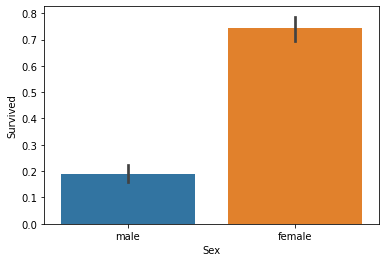

In [5]:
sns.barplot(x="Sex",y="Survived", data=train)

print(train[['Survived','Sex']].groupby(['Sex']).mean())
pd.crosstab(train['Sex'],train['Survived'])

We can see from the barplot above that a higher percentage of female have survived compared to male

#####  Feature 'Pclass':

1    136
0     80
Name: Survived, dtype: int64
0    97
1    87
Name: Survived, dtype: int64
0    372
1    119
Name: Survived, dtype: int64


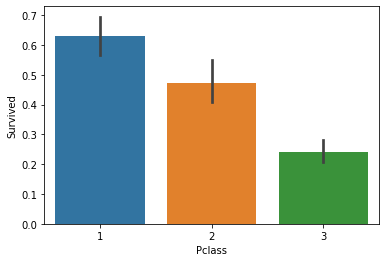

In [6]:
sns.barplot(x="Pclass",y="Survived",data=train)

print(train["Survived"][train["Pclass"]==1].value_counts())
print(train["Survived"][train["Pclass"]==2].value_counts())
print(train["Survived"][train["Pclass"]==3].value_counts())

#train[['Survived','Pclass']].sum()

We can see from the barplot above that a better chances of people surviving if they are from better PClass

##### Feature 'Parch' and 'SibSp':

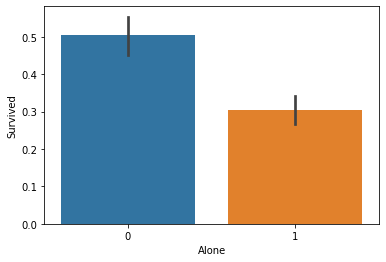

In [7]:
# I think it would be more sensible to make a feature is a person is alone or with family.
# So to make that I combine parent children and Sibling spouse features.
# If after combining their values it is 0 then the person is travelling by himself/herself.

train['FamilySize']=train['Parch']+train['SibSp']
test['FamilySize']=test['Parch']+test['SibSp']

train['Alone']=0
test['Alone']=0
train.loc[train['FamilySize']==0,'Alone']=1
test.loc[test['FamilySize']==0,'Alone']=1
sns.barplot(x='Alone',y='Survived',data=train)

People alone are more likely to die compared to people with family

##### Feature 'Age':

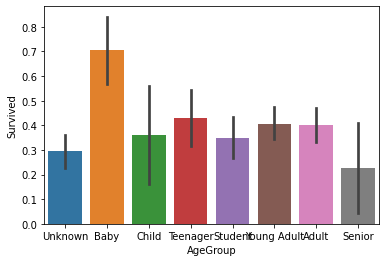

In [8]:
# In Age we have seen that there are huge number of values that are missing so we need to find a way to fill those
# As age can be one of the important features

#So first we categorise the KNOWN age into few bins with the missing(filled with -0.5) ones into the category 'UNKNOWN'

train['Age']=train['Age'].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)
#train['AgeGroup'].unique()
#draw a bar plot of Age vs. survival
sns.barplot(x="AgeGroup", y="Survived", data=train)

##### Feature 'Title':

Here we shall extract titles from 'Name' and use them for further use as the Name is not of much use

In [9]:
train['title']=train['Name'].str.extract(pat = '([A-Za-z]+)\.') 
test['title']=test['Name'].str.extract(pat = '([A-Za-z]+)\.') 
print(train['title'].value_counts())
#pd.crosstab(train['title'],train['Survived'])

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Ms            1
Countess      1
Mme           1
Jonkheer      1
Don           1
Lady          1
Sir           1
Capt          1
Name: title, dtype: int64


In [10]:
#Trying to reduce the categories into more logical terms

for data in comb:
    data['title']=data['title'].replace(['Capt','Col','Don','Dr','Major','Rev','Jonkheer','Dona'],'Rare')
    data['title']=data['title'].replace(['Mme'],'Mrs')
    data['title']=data['title'].replace(['Mlle','Ms'],'Miss')
    data['title']=data['title'].replace(['Countess','Sir','Lady'],'Royal')

train['title'].value_counts()
pd.crosstab(train['title'],train['Survived'])

Survived,0,1
title,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Rare,15,5
Royal,0,3


For the missing Age I have thought of replacing them with the mode of age-group occuring for the that corresponding title

In [11]:
title_map={'Mr':1, 'Master':2, 'Miss':3, 'Mrs':4, 'Rare':5, 'Royal':6}
for dataset in comb:
    dataset['title'] = dataset['title'].map(title_map)

print(train[['title']].head())
#Calculating which age group occurs max for a particular title

mr_age = train[train["title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = train[train["title"] == 2]["AgeGroup"].mode() #Student
mrs_age = train[train["title"] == 3]["AgeGroup"].mode() #Adult
master_age = train[train["title"] == 4]["AgeGroup"].mode() #Baby
royal_age = train[train["title"] == 5]["AgeGroup"].mode() #Adult
rare_age = train[train["title"] == 6]["AgeGroup"].mode() #Senior

   title
0      1
1      4
2      3
3      4
4      1


In [12]:
age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["title"][x]]

for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["title"][x]]

##### Feature 'Cabin':

I am making the feature 'Cabin' to check if a person has a cabin or not. Its number is irrelevant in my case.

         Survived
isCabin          
0        0.299854
1        0.666667


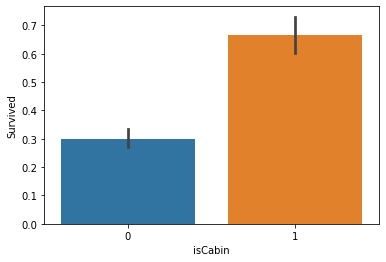

In [13]:
train['isCabin']=0
train.loc[train['Cabin'].notnull(),'isCabin']=1
test['isCabin']=0
test.loc[test['Cabin'].notnull(),'isCabin']=1

print(train[['isCabin','Survived']].groupby(['isCabin']).mean())
sns.barplot(x='isCabin',y='Survived',data=train)

We can see that people with Cabin are more likely to survive than the ones without

          Survived
Embarked          
C               93
Q               30
S              217
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957


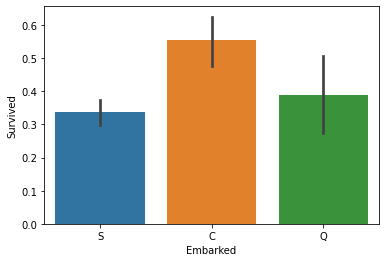

In [14]:
print(train[['Embarked','Survived']].groupby(['Embarked']).sum())
print(train[['Embarked','Survived']].groupby(['Embarked']).mean())
sns.barplot(x='Embarked',y='Survived',data=train)

In [15]:
# Since a very high percentage of passengers have 'Embarked' as S we 
# are filling the missing 2 as 'S' and also mapping them

train['Embarked']=train['Embarked'].fillna('S')
train['Embarked']=train['Embarked'].map({"S":1, "C":2, "Q":3})
test['Embarked']=test['Embarked'].map({"S":1, "C":2, "Q":3})

In [16]:
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
train['AgeGroup']=train['AgeGroup'].map(age_mapping)
test['AgeGroup']=test['AgeGroup'].map(age_mapping)

In [17]:
train['Sex']=train['Sex'].map({"male":0, "female":1})
test['Sex']=test['Sex'].map({"male":0, "female":1})

##### Feature 'Fare':

The missing fares are filled with the mean of that corresponding 'Pclass'

In [18]:
for x in range(len(test['Fare'])):
    if pd.isnull(test['Fare'][x]):
        test['Fare'][x] = round(train['Fare'][train['Pclass']==test['Pclass'][x]].mean(), 4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


FareBand will categorise the fare into 4 categories

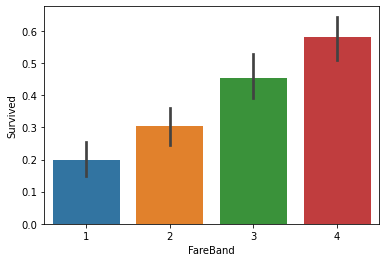

In [19]:
train['FareBand']=pd.qcut(train['Fare'], 4, labels=[1,2,3,4])
test['FareBand']=pd.qcut(test['Fare'], 4, labels=[1,2,3,4])
sns.barplot(x='FareBand', y='Survived', data=train)

Now that we have seen the features, we shall move to the training. For that we first drop the columns that we shall not use.

In [20]:
train1=train.drop(columns=['Cabin','Ticket','Age','FamilySize','SibSp','Parch','Name','Fare','PassengerId','Survived','AgeGroup'])
test1=test.drop(columns=['Cabin','Ticket','Age','FamilySize','SibSp','Parch','Name','Fare','PassengerId','AgeGroup'])

In [21]:
train1.head()

,Pclass,Sex,Embarked,Alone,title,isCabin,FareBand
0,3,0,1,0,1,0,1
1,1,1,2,0,4,1,4
2,3,1,1,1,3,0,2
3,1,1,1,0,4,1,4
4,3,0,1,1,1,0,2


In [22]:
test1.head()

,Pclass,Sex,Embarked,Alone,title,isCabin,FareBand
0,3,0,3,1,1,0,1
1,3,1,1,0,4,0,1
2,2,0,3,1,1,0,2
3,3,0,1,1,1,0,2
4,3,1,1,0,4,0,2


In [23]:
from sklearn.model_selection import train_test_split

target = train['Survived']
x_train,x_val,y_train,y_val = train_test_split(train1,target,test_size = 0.2, random_state=0)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(x_train,y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100,2)
print(acc_gaussian)

77.65


In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val)*100, 2)
print(acc_logreg)

74.86


In [26]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

78.77


In [27]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

75.98


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [28]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

76.54


In [29]:
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

79.89


In [30]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

81.56


In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

82.68


In [32]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

61.45


In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

82.68


In [34]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,KNN,82.68
9,Gradient Boosting Classifier,82.68
3,Random Forest,81.56
7,Decision Tree,79.89
0,Support Vector Machines,78.77
4,Naive Bayes,77.65
5,Perceptron,76.54
6,Linear SVC,75.98
2,Logistic Regression,74.86
8,Stochastic Gradient Descent,61.45


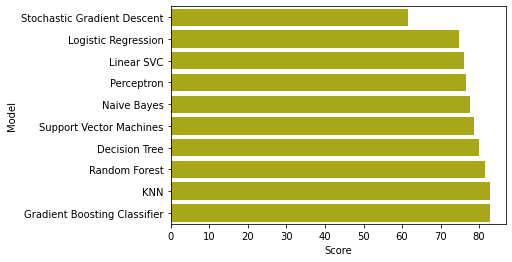

In [35]:
sns.barplot(x='Score', y='Model', data=models.sort_values(by=["Score"]), color="y")

In [36]:
ids = test['PassengerId']
predictions = gbk.predict(test1)

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submissions.csv', index=False)